#### MSIN0114-Dissertation-Procurement Strategies - XGGZ9 
***UCL Business Analytics Course Final Thesis Notebook***

----

### Summary

The following notebook illustrates the development of three aluminium procurement strategies for company ABC (annoymised company name) by utilising the aluminium pricing engine built out in the code repo. Utilising this company's true procurement records as a reference, these three strategies are back-tested over the same periods.
One of them is selected as the procurement decision engine that we would recommend, showcasing the best balance between procurement cost reductions and stock-out risk controls. Detailed below are summaries of the approach and the impact assessment.

### Three Approaches

1. **Baseline**: 
    - Purchase Aluminium on a daily basis where the purchase amount is average daily aluminium usage in the past year
    
2. **Arbitrary**:
    - Utilising the Aluminium pricing forecasting engine (LSTM) to forecast the one-month-low day for the month. The purchase amount each time is
    
    
3. **Refined Strategy**: 
    - Combining the following:
        1. Aluminium pricing forecasting engine
        2. Aluminium price movement directions of change (Short-term and Medium-term)
        3. Stock Level of aluminium
      
      to decide when and how much aluminium should be purchased

### Results and Impact

>Orginal Annual Spending at ABC Company for Alumnium Raw Material is roughly **49.73M CNY**

With the above three approaches applied, new annual spending is back-tested and estimated to be (`unit=1 CNY`):

| | Baseline | Arbitrary | Refined Strategy |
| --- | --- | --- | --- |
| New Annual Spending | 49.71M | 48.05M | 48.33M |
| Average Unit Cost (Per Ton) | 19,130 | 18,502 | 18,607 |
| Reduction in Cost (%) |0.08 | 3.37 | 2.89 |

----
**Details:**
Compared to ABC Company's true record of ordering aluminium, the back-testing of three strategies quantitatively showed that all the devised strategies could have brought about procurement cost reduction.


- The Baseline Strategy reduced the procurement cost by only 0.08%. However, by regularly procuring aluminium every day, this strategy ensures stable aluminium stock and procurement spending for the company, preventing both understock and overstock problems.


- The application of the Arbitrary Strategy could have achieved the most remarkable reduction in procurement cost by 3.37%. However, the fixed one-time purchase per month inherently indicates uncertainty, inadaptivity, and over-reliance on the aluminium price forecasting model's accuracy, which could be highly risky.


- The Refined Strategy, on the other hand, shows the best balance between cost reduction by 2.89% - only 0.47% less than the arbitrary one - and risk control. It is selected as the final aluminium procurement decision engine that we would recommend the ABC Company to apply in practive.

### Section 0 - Preparation

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline


# fix random seed for reproducibility
tf.random.set_seed(7)

**Current Company ABC Status**

*Timeframe*
- 2022-03-31 and 2023-03-31

*Amount*
- daily amount of aluminium usage is 7.2 tons
- monthly amount of aluminium usage is 216 tons

*Costs*
- 49.7M CNY in total
- average unit price of 19,147 CNY/Ton

In [2]:
company_abc_actual_spend=49729144 #hard-coded for privacy
company_abc_actual_unit_cost=19147

**Data Loading**

In [3]:
scaled_cleaned_data = pd.read_csv('../data/processed/scaled_cleaned_data.csv')
cleaned_data=pd.read_csv('../data/processed/cleaned_data.csv')

aluminium_price=cleaned_data[['DATE','AL_PRICE']].copy()
aluminium_price['DATE']=pd.to_datetime(aluminium_price['DATE'])

**Processing For Further Analysis / Cost Calculation**

In [4]:
date_range = pd.date_range(start='2022-03-31', end='2023-03-31')
procurement_period = pd.DataFrame({'DATE': date_range})

# The corresponding period' true aluminium prices:
procurement_test = aluminium_price[(aluminium_price['DATE']>='2022-03-31')&(aluminium_price['DATE']<='2023-03-31')]

procurement_period=procurement_period.merge(procurement_test, on="DATE", how="left")
procurement_period=procurement_period.ffill()

----

### Section 1. Baseline Strategy - Purchase Every Day

- This strategy straightforadly implies purchasing aluminium regularly at 7 tons every day. This is designed to diverse impacts of price volatilities over time.

**Calculate Annual Cost**

In [5]:
#make a copy
baseline_strategy = procurement_period.copy()

#Feature engineering
baseline_strategy['JIT_WEIGHT']=7.1 # original calculation omited
baseline_strategy['JIT_COST']=baseline_strategy['JIT_WEIGHT']*baseline_strategy['AL_PRICE']

baseline_strategy_annual=baseline_strategy.JIT_COST.sum()
print(f"Baseline Strategy annual spending:", baseline_strategy_annual)

strategy_1_unit=baseline_strategy.JIT_COST.sum()/baseline_strategy.JIT_WEIGHT.sum()
print(f"Baseline Strategy unit procurement cost:", strategy_1_unit)

Baseline Strategy annual spending: 49713241.5
Baseline Strategy unit procurement cost: 19130.77868852459


**Results**
- expected total cost during the tested period is 49.71M CHY
- unit cost 19,131 CHY/ton

----

### Section 2. Arbitrary Strategy - Purchase Once Per Month Based on AL Price Prediction Engine

* In this approach, We forecast the next month's aluminium price at the end of each month. Under this scenario, a single procurement order for an expected 210 tons (assuming 30-day months) is placed on the date corresponding to the forecasted lowest aluminium price for that month


**Re-use the LSTM Model from AL Pricing Engine (PLEASE SKIP)**
>A Quick/Dirty Version is Provided Here, more organised LSTM model pipeline can be found in the repo

In [6]:
# trains an LSTM model and makes predictions for a specified number of future days
def lstm_new(day_pred_diff, start_day):
    train_df = scaled_cleaned_data.head(start_day).drop("DATE", axis=1).copy()
    x_train = train_df.loc[:, train_df.columns != 'AL_PRICE'].copy()
    y_train = train_df['AL_PRICE'].copy()
    x_train = tf.convert_to_tensor(x_train.to_numpy())
    x_train = tf.expand_dims(x_train, 1)
    y_train = tf.convert_to_tensor(y_train.to_numpy())
    
    
    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(64)) 
    model.add(Dense(4))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict
    prediction_start_time = start_day
    prediction_end_time = day_pred_diff + start_day
    temporary_test_dataframe = scaled_cleaned_data.drop("DATE", axis=1).iloc[prediction_start_time:prediction_end_time].copy()
    x_test = temporary_test_dataframe.loc[:, temporary_test_dataframe.columns != 'AL_PRICE'].copy()
    x_test = tf.convert_to_tensor(x_test.to_numpy())
    x_test = tf.expand_dims(x_test, 1)
    
    lstm_results = model.predict(x_test)
    lstm_results_as_list = [i[0] for i in lstm_results]
    
    return lstm_results_as_list

In [7]:
# Define the ranges for slicing
# Note that we used row number to define date range, not actual dates
date_ranges = [
    (1372, 1391), #0: April:2022-03-31 to 2022-04-30
    (1392, 1410), #1: May: 2022-04-30 to 2022-05-31
    (1410, 1431), #2: June: 2022-05-31 to 2022-06-30
    (1431, 1452), #3: July: 2022-06-30 to 2022-07-31
    (1453, 1475), #4: August: 2022-07-31 to 2022-08-31
    (1475, 1496), #5: Sep: 2022-08-31 to 2022-09-30
    (1496, 1512), #6: Oct: 2022-09-30 to 2022-10-31
    (1512, 1534), #7: Nov: 2022-10-31 to 2022-11-30
    (1534, 1556), #8: Dec: 2022-11-30 to 2022-12-31
    (1557, 1572), #9: Jan23: 2022-12-31 to 2023-01-31
    (1572, 1592), #10: Feb23: 2023-01-31 to 2023-02-28
    (1592, 1615), #11: March23: 2023-02-28 to 2023-03-31
    (1615, 1634), #12: April23: 2023-03-31 to 2023-04-30
]

# initialise
test_scaled = [] #scaled dataframe, features scaled withn MinMaxScaler()
test_real = [] # real dataframe to conclude real al futures prices and calculate unit procurement cost
y_real = [] # the real al futures prices
y_scaled = [] # scaled al futures prices

# train interatively
for start, end in date_ranges:
    test_scaled_df = scaled_cleaned_data.iloc[start:end].copy()
    test_real_df = aluminium_price.iloc[start:end].copy()
    y_series_real = test_real_df['AL_PRICE']
    y_series_scaled = test_scaled_df['AL_PRICE']
    
    
    test_scaled.append(test_scaled_df)
    test_real.append(test_real_df)
    y_real.append(y_series_real)
    y_scaled.append(y_series_scaled)

**Monthly Forecasting**

1/1 [==============================] - 0s 453ms/step


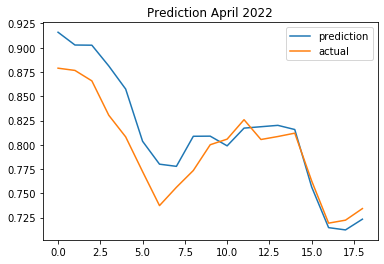

1/1 [==============================] - 0s 345ms/step


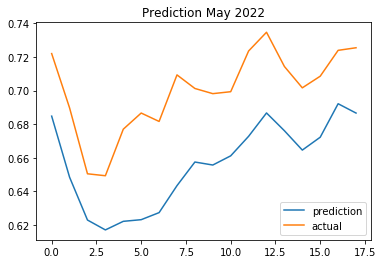

1/1 [==============================] - 0s 353ms/step


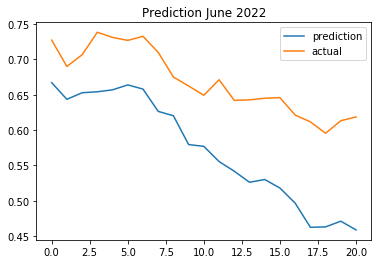

1/1 [==============================] - 0s 369ms/step


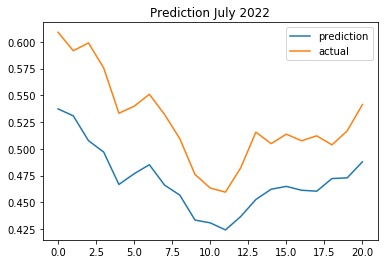

1/1 [==============================] - 0s 346ms/step


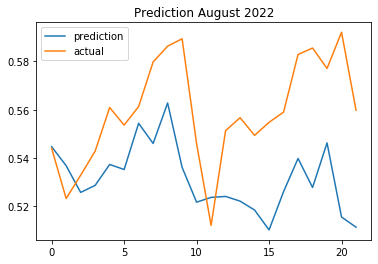

1/1 [==============================] - 0s 379ms/step


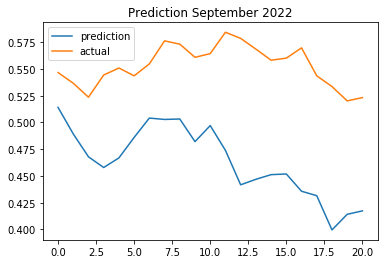

1/1 [==============================] - 0s 432ms/step


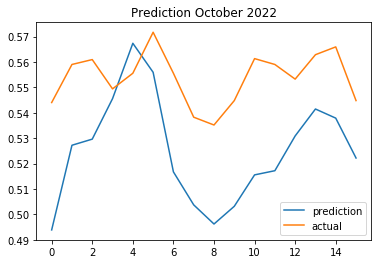

1/1 [==============================] - 0s 385ms/step


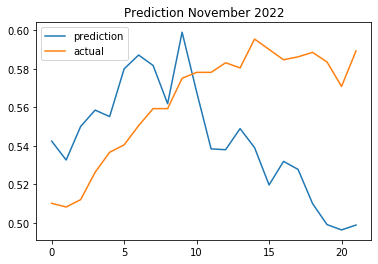

1/1 [==============================] - 0s 363ms/step


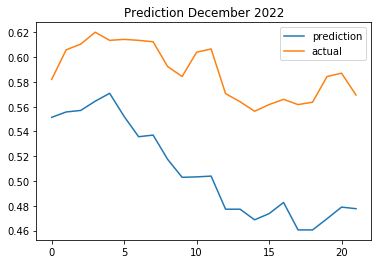

1/1 [==============================] - 0s 382ms/step


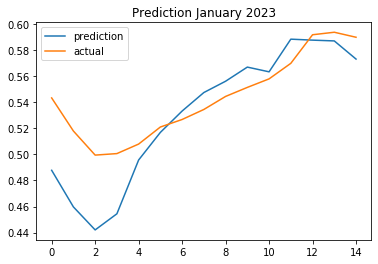

1/1 [==============================] - 0s 419ms/step


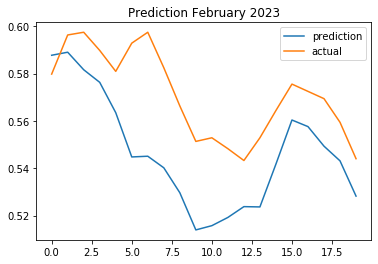

1/1 [==============================] - 0s 443ms/step


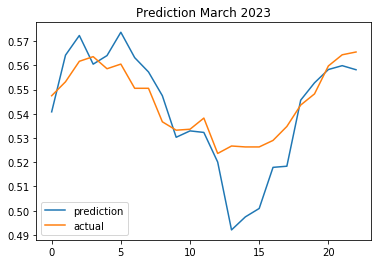

1/1 [==============================] - 0s 373ms/step


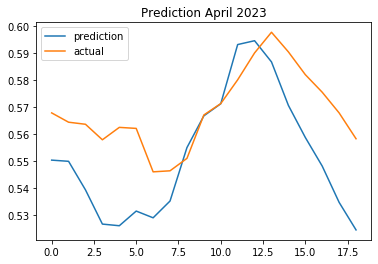

In [8]:
# Parameters for each month
predictions = [
    (19, 1372, 'April 2022', y_scaled[0]), #1972 represents the row index corresponding to 2022-03-31
    (18, 1392, 'May 2022', y_scaled[1]),
    (21, 1410, 'June 2022', y_scaled[2]),
    (21, 1431, 'July 2022', y_scaled[3]),
    (22, 1453, 'August 2022', y_scaled[4]),
    (21, 1475, 'September 2022', y_scaled[5]),
    (16, 1496, 'October 2022', y_scaled[6]),
    (22, 1512, 'November 2022', y_scaled[7]),
    (22, 1534, 'December 2022', y_scaled[8]),
    (15, 1557, 'January 2023', y_scaled[9]),
    (20, 1572, 'February 2023', y_scaled[10]),
    (23, 1592, 'March 2023', y_scaled[11]),
    (19, 1615, 'April 2023', y_scaled[12]),
]
#Column 1 indicates the rows' indices corresponding to the starting date to be forecasted
#Column 0 is the number of trading days in that month
#E.g., 1972 represents the row index corresponding to 2022-03-31, 19 represents number of trading days in April


# Iterate through predictions and plot
for day_pred_diff, start_day, month, y in predictions:
    lstm_predictions = lstm_new(day_pred_diff=day_pred_diff, start_day=start_day)
    plt.plot(np.arange(len(lstm_predictions)), lstm_predictions, label="prediction")
    plt.plot(np.arange(len(y)), y, label="actual")
    plt.legend()
    plt.title(f'Prediction {month}')
    plt.show()

**Additional Information on the Cheapest Monthly Point**

In [9]:
lstm_predictions=[y for _, _, _, y in predictions]
y_lstm = [series.tolist() for series in lstm_predictions] #extract forecasted al_price in each month

LSTM_Min=[]
for values, df in zip(y_lstm, test_real):

    min_value = min(values)
    min_index = values.index(min_value)
    corresponding_date = df.iloc[min_index]['DATE']
    corresponding_price = df.iloc[min_index]['AL_PRICE']
    LSTM_Min.append(corresponding_price)
    print(f'lstm identified best date is {corresponding_date}, corresponding AL_PRICE in test_real: {corresponding_price}')

lstm identified best date is 2022-04-26 00:00:00, corresponding AL_PRICE in test_real: 20680.0
lstm identified best date is 2022-05-10 00:00:00, corresponding AL_PRICE in test_real: 19770.0
lstm identified best date is 2022-06-27 00:00:00, corresponding AL_PRICE in test_real: 19070.0
lstm identified best date is 2022-07-15 00:00:00, corresponding AL_PRICE in test_real: 17300.0
lstm identified best date is 2022-08-16 00:00:00, corresponding AL_PRICE in test_real: 17985.0
lstm identified best date is 2022-09-28 00:00:00, corresponding AL_PRICE in test_real: 18090.0
lstm identified best date is 2022-10-19 00:00:00, corresponding AL_PRICE in test_real: 18285.0
lstm identified best date is 2022-11-01 00:00:00, corresponding AL_PRICE in test_real: 17935.0
lstm identified best date is 2022-12-20 00:00:00, corresponding AL_PRICE in test_real: 18560.0
lstm identified best date is 2023-01-05 00:00:00, corresponding AL_PRICE in test_real: 17820.0
lstm identified best date is 2023-02-16 00:00:00, 

**Calculate Costs**

In [10]:
# Under This Scenario: 
monthly_demand= 216.437 #Assumption:constant monthly demand
arbitrary_strategy_annual_cost=sum(value * monthly_demand for value in LSTM_Min[0:12])#from 2022-03-31 to 2023-03-31
print(f"Arbitrary strategy annual spending:", arbitrary_strategy_annual_cost)

arbitrary_strategy_unit_cost=sum(value * monthly_demand for value in LSTM_Min[0:12])/monthly_demand/12
print(f"Arbitrary strategy unit procurement cost:", arbitrary_strategy_unit_cost)

Arbitrary strategy annual spending: 48053342.74
Arbitrary strategy unit procurement cost: 18501.666666666668


**Results**
- The expected annual cost for procuring the same amount of aluminium is 48.05M CHY
- The unit cost is 18,502 CHY/ton

### 3. Refined Strategy

A pusedo-code is shared below to illustrate the logic behind this approach (reader is advised to skip the coding section)

on each candidate restocking date (candidate restocking date referring to date on which we consider al purchase)

**Part 1 - Locating the first candidate restocking day**
- 1.1: use al pricing prediction engine to predict prices for the next 22 trading days
- 1.2: group together first 10 days name it group A
- 1.3: locate the date with the lowest forecasted al price, this is the first candidate restocking date


**Part 2 - Locating other candidate restocking dates**
- 2.1: on the previous candidate restocking date identified, forecast prices fore another 22 days
- 2.2: locate the next date with the lowest forecasted al price for the next 10 trading days, this date is the next candidate restocking date
- 2.3: repeate steps of 2.1 and 2.3

**Part 3 - Make procurement decisions on each candidate restocking date**

- **3.1: Calculations:**

    - 3.1.1: SLOPE: the slope of the line of the best fit of the linear regression among the 22 forecasted datapoints, indicating a monthly price movement tendency
    - 3.1.2: SLOPE_2: the percentage price difference between the next forecasted candadate restocking date's al price and the current al_price, indicating a short-run price movement tendency
    - 3.1.3: DAYS_DIFF: the difference in days between two consecutive candidate restocking dates
    - 3.1.4: DECISION: if both SLOPE and SLOPE_2 are positive, DECISION ==1; otherwise, DECISION ==2. This is a double filter for determing al price's movement tendency



- **3.2: Rules:**

    - If DECISION = 1 and if stock level >300, purchase 7*DAYS_DIFF, because we do not want too much stock while we want to take advantage of possibly low unit procurement costs;
    - If DECISION =1 and if stock level <121 (the Reorder Point), purchase 7*DAYS_DIFF+(300-current stock level). This is because we are at the risk of stockout while we believe that unit procurement cost is relatively low;
    - IF DECISION != 1 and if stock level <121, purchase 7*DAYS_DIFF. Despite of higher unit procurement cost, we decide to restock to avoid stockout risks;
    - Otherwise, do not re-stock.


**Re-use the LSTM Model from AL Pricing Engine (PLEASE SKIP)**
>A Quick/Dirty Version is Provided Here, more organised LSTM model pipeline can be found in the repo

In [11]:
#trains an LSTM model and makes predictions for a specified number of future days
def lstm_pred_day(day_pred_diff, additional_day = 0):
    train_df = scaled_cleaned_data.head(978+additional_day).drop('DATE',axis=1).copy()
    x_train = train_df.loc[:, train_df.columns != 'AL_PRICE'].copy()
    y_train = train_df['AL_PRICE'].copy()
    x_train = tf.convert_to_tensor(x_train.to_numpy())
    x_train = tf.expand_dims(x_train, 1)
    y_train = tf.convert_to_tensor(y_train.to_numpy())
    
    
    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(64))  
    model.add(Dense(4))  
    model.add(Dense(1)) 
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict
    prediction_starting_time = 1000-22+additional_day
    prediction_end_time = day_pred_diff + 1000-22 + additional_day
    temporary_test_dataframe = scaled_cleaned_data.iloc[prediction_starting_time:prediction_end_time].drop('DATE',axis=1).copy()
    x_test = temporary_test_dataframe.loc[:, temporary_test_dataframe.columns != 'AL_PRICE'].copy()
    x_test = tf.convert_to_tensor(x_test.to_numpy())
    x_test = tf.expand_dims(x_test, 1)
    
    lstm_results = model.predict(x_test)
    lstm_results_in_list = [i[0] for i in lstm_results]

    
    return lstm_results_in_list

**Prediction in a 22-day Rolling Window**

In [12]:
%%capture

out = []
day_pred_diff =22
for i, day in enumerate(np.arange(0,631,day_pred_diff)):
    print(i)
    out.append(lstm_pred_day(day_pred_diff = day_pred_diff, additional_day = day))
refined_strategy_lstm_results = np.concatenate(out)

**Compute Trend For The Next 22 Days of Trading Day (Based on AL Pricing Prediction Engine)**

- This is to see if there is a upward or downward trend in the aluminium prices in the aluminium price prediction from next 22 trading days

In [13]:
def compute_slopes_and_correlations(series):
    window_size = 22
    slopes = []
    correlation_coeffs = []

    # Rolling through the series with a window of 22
    for i in range(len(series) - window_size + 1):
        window = series[i:i + window_size]
        x = np.arange(window_size)

        # Using linear regression to compute slope, intercept, and correlation coefficient
        slope, intercept, r_value, _, _ = linregress(x, window)

        slopes.append(slope)
        correlation_coeffs.append(r_value**2)

    return slopes, correlation_coeffs

slopes, correlation_coeffs = compute_slopes_and_correlations(refined_strategy_lstm_results[394:638]) #394 is the 2022-03-31
# Creating a DataFrame with slopes and correlation_coeffs
slopes = pd.DataFrame({
    'Slopes': slopes,
    'Correlation_Coefficients': correlation_coeffs
})

# Extract true values of the same period from 2022-03-31 to 2023-03-31
slope_test_true_set=cleaned_data[1372:1616].reset_index(drop=True)
slope_test_predicted_set=pd.DataFrame({'Prediction':refined_strategy_lstm_results[394:638]})
slope_test_predicted_set['True']=slope_test_true_set['AL_PRICE']
slope_test_predicted_set['DATE']=slope_test_true_set['DATE']
slope_test_predicted_set['Slope']=slopes['Slopes']

#drop null values
slope_test_set=slope_test_predicted_set.dropna()
slope_test_set.columns = slope_test_set.columns.str.upper()

#preview
slope_test_set.head(5)

,PREDICTION,TRUE,DATE,SLOPE
0,0.947028,22755.0,2022-03-31,-0.010854
1,0.926425,22725.0,2022-04-01,-0.010749
2,0.883188,22585.0,2022-04-06,-0.010686
3,0.862023,22125.0,2022-04-07,-0.010235
4,0.838987,21835.0,2022-04-08,-0.009741


Create a function that rolls over the DataFrame every 22 rows 
and extracts the row with the lowest prediction only if the corresponding slope is 1

In [14]:
def encode_values(value):
    # encode slopes
    if value > 0:
        return 1
    elif value < 0:
        return -1
    else:
        return 0

def get_min_prediction_rows(df, freq):
    # Resample
    min_pred_idx = df.resample(freq)['PREDICTION'].idxmin()
    min_pred_rows = df.loc[min_pred_idx]

    min_pred_rows['SLOPE_2'] = np.sign(min_pred_rows['PREDICTION'].pct_change()).shift(-1)
    min_pred_rows['DECISION'] = min_pred_rows['SLOPE'] + min_pred_rows['SLOPE_2']
    
    # Apply a transformation
    min_pred_rows['DECISION'] = min_pred_rows['DECISION'].apply(lambda x: 1 if x == 2 else 0)
    
    return min_pred_rows.reset_index()

slope_test_set['SLOPE'] = slope_test_set['SLOPE'].apply(encode_values)
slope_test_set_copy = slope_test_set.copy()
slope_test_set_copy['DATE'] = pd.to_datetime(slope_test_set_copy['DATE'])
slope_test_set_copy.set_index('DATE', inplace=True)

# Get the result for each desired frequency
#min_pred_rows_per_month = get_min_prediction_rows(slope_test_set_copy, 'M')
#min_pred_rows_per_15D = get_min_prediction_rows(slope_test_set_copy, '15D')
min_pred_rows_per_10D = get_min_prediction_rows(slope_test_set_copy, '10D')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
# Calculate the difference between consecutive dates
min_pred_rows_per_10D['DAYS_DIFF']=min_pred_rows_per_10D['DATE'].diff().dt.days

In [16]:
# We can manually calculate the difference between 2022-03-31 and 2022-04-08
min_pred_rows_per_10D['DAYS_DIFF']=min_pred_rows_per_10D['DAYS_DIFF'].fillna(8)

In [17]:
refined_strategy_dataset=min_pred_rows_per_10D.copy()

In [19]:
# Create new columns for restocking information
refined_strategy_dataset['RESTOCKING_DATE'] = False
refined_strategy_dataset['RESTOCKED_AMOUNT'] = 0.0

# Start with the first row's stock level
stock_level = 300 - 7 * refined_strategy_dataset.loc[0, 'DAYS_DIFF']
refined_strategy_dataset.loc[0, 'STOCK_LEVEL'] = stock_level

# Iterate through the remaining rows
for i in range(1, len(refined_strategy_dataset) - 1): # Modified loop range to exclude last row
    # Continue decreasing the stock level by 7 times the current row's DAYS_DIFF
    stock_level -= 7 * refined_strategy_dataset.loc[i, 'DAYS_DIFF']
    
    restocked_amount = 0 # Initialize restocked amount
    
    # Check for re-stock conditions
    if refined_strategy_dataset.loc[i, 'DECISION'] == 1 and stock_level < 300:
        restocked_amount = 7 * refined_strategy_dataset.loc[i+1, 'DAYS_DIFF']+(300 - stock_level)
        stock_level = stock_level + restocked_amount
        
    elif refined_strategy_dataset.loc[i, 'DECISION'] == 1 and stock_level > 300:
        restocked_amount = 7 * refined_strategy_dataset.loc[i+1, 'DAYS_DIFF']
        stock_level += restocked_amount
        
    elif refined_strategy_dataset.loc[i, 'DECISION'] != 1 and stock_level < 121:
        restocked_amount = 7 * refined_strategy_dataset.loc[i+1, 'DAYS_DIFF']
        stock_level += restocked_amount
        
    else:
        restocked_amount = 0   
        
        
    # Update restocking information in the DataFrame
    if restocked_amount > 0:
        refined_strategy_dataset.loc[i, 'RESTOCKING_DATE'] = True
        refined_strategy_dataset.loc[i, 'RESTOCKED_AMOUNT'] = restocked_amount

    # Update the stock level in the DataFrame
    refined_strategy_dataset.loc[i, 'STOCK_LEVEL'] = stock_level

# Handle the last row separately to avoid index error
i = len(refined_strategy_dataset) - 1
stock_level -= 7 * refined_strategy_dataset.loc[i, 'DAYS_DIFF']
refined_strategy_dataset.loc[i, 'STOCK_LEVEL'] = stock_level

In [21]:
restocking = refined_strategy_dataset[refined_strategy_dataset['RESTOCKING_DATE']==True]
restocking['PROCUREMENT']=restocking['TRUE']*restocking['RESTOCKED_AMOUNT']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Results**

In [23]:
# restocking value from 2022-03-31 to 2023-02-13
restocking.PROCUREMENT.sum()

41680765.0

In [24]:
# restocking amount from 2022-03-31 to 2023-02-13
restocking.RESTOCKED_AMOUNT.sum()

2240.0

In [25]:
refined_strategy_unit = restocking.PROCUREMENT.sum()/restocking.RESTOCKED_AMOUNT.sum()
refined_strategy_annual = (restocking.PROCUREMENT.sum()/restocking.RESTOCKED_AMOUNT.sum())*monthly_demand*12
print(f"Refined Strategy unit procurement cost:", refined_strategy_unit)
print(f"Refined Strategy annual spending:", refined_strategy_annual)

Refined Strategy unit procurement cost: 18607.484375
Refined Strategy annual spending: 48328177.148062505
